In [55]:
import torchtext
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torchtext.data import Field,LabelField
from torchtext.data import Example
from sklearn.model_selection import train_test_split
from torchtext import data
import time
import spacy
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

# Exploring Text Classification for Hackathon.

https://www.machinehack.com/course/classifying-movie-scripts-predict-the-movie-genre/

The problem gives you the whole text from a movie script and you need to classify it into one of the genres. 


### Summarise the approach

Some useful references:

This is a starter for looking at using torchtext and then inputting the result into a LSTM. The problem here is that I think our corpus of text is too long for LSTM.

https://www.kaggle.com/swarnabha/pytorch-text-classification-torchtext-lstm


This second approach uses an embeddingbag - which averages out the embedding values. This is better for our application as we can compare the approach on scripts of different lengths. It also looks at using ngrams.

So we take all the words (each has a vector - of say 200 length) and we average it for all words. That will give us one vector that's then the same length for all movie scripts. You must remove a lot of information in that averaging. 

https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Input

In [57]:
df= pd.read_csv("torchtext_data/train.csv")
df = df.rename(columns = {'Script':'text','Labels':'target'})
#df = df[0:10]
#df

,target,text
0,8,"\t\t\tCrouching Tiger, Hidden Dragon\n\n\t\t\t..."
1,4,"""MUMFO..."
2,6,MAX PAYNE\n\n ...
3,6,SLUMDOG MILLIONAIRE\n\n ...
4,16,<b><!--\n\n</b>if (window!= top)\n\ntop.locati...
5,15,THE OTHER BOLEYN GIR...
6,19,GET CARTER...
7,15,"CRAZY, STUPID, LOV..."
8,1,TRISTAN + ...
9,6,BADLANDS\n\nby Terence Malick\n\nFinal Version...


# Tokenizer

In [58]:
# Tokenizer -S egment text into words, punctuations marks etc.

# Was going to use spacy but I can't get it to work.
spacy = spacy.load("en_core_web_sm")

# nltk.download('punkt')

from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

tokens = tokenizer(df['text'][1])
print('Here is an example of what tokenizer does {}'.format(tokens[0:10]))

Here is an example of what tokenizer does ['mumford', 'screenplay', 'by', 'lawrence', 'kasdan', 'shooting', 'draft', 'ext', '.', 'main']


# Some Basic Cleaning

In [59]:
# Complete some basic text cleaning.
# Manually removing things like punctuation.
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [60]:
df['text'] = normalise_text(df['text'])

In [61]:
#Split the data into training and tes
train_df, valid_df = train_test_split(df)

In [62]:
# For each (top 5) of the entries in the train dataset how many tokens are there.
train_df['text'].str.len().head()

1540    151217
1486    122947
1594    166672
864     117277
75      128172
Name: text, dtype: int64

# Data Analysis

- How many classes
- is there class inbalance
- what's the size range of the different text examples

In [72]:
num_classes = train_df['target'].nunique()
print('There are {} classes'.format(num_classes))

There are 22 classes


Text(0.5, 1.0, 'Analysing the class imbalance')

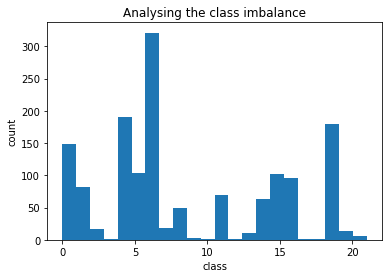

In [70]:
plt.hist(train_df['target'], bins=num_classes)
plt.xlabel('class')
plt.ylabel('count')
plt.title('Analysing the class imbalance')

There's a massive class imbalance. 

Text(0.5, 1.0, 'How the length of the script varies')

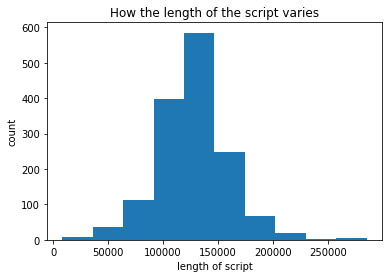

In [79]:
plt.hist(train_df['text'].apply(len))
plt.xlabel('length of script')
plt.ylabel('count')
plt.title('How the length of the script varies')

In [25]:
# Option to add in sequential = True here. Look into this. 

# set up for using pytorch text implementations.
TEXT = Field(tokenize=tokenizer, include_lengths = True )  # fix_length= 20000 
LABEL = LabelField(dtype=torch.long)

In [26]:
# Create a pytorch dataset.
def create_dataset(df):
    # Do we need to add one example at a time.
    fields = [('text',TEXT),('label', LABEL)]
    examples_prep = []
    for i, row in df.iterrows():
        label = row.target
        text = row.text
        examples_prep.append(Example.fromlist([text,label], fields))

    dataset_output = torchtext.data.Dataset(examples = examples_prep, fields=fields)
    return dataset_output

In [27]:
train_ds = create_dataset(train_df)
valid_ds = create_dataset(valid_df)

In [30]:
train_ds[0]

In [31]:
print(len(train_ds[2].text))

28999


# Embeddings. 
You want to be able to convert each word into a vector that has some meaning. If you used one hot encoding you'd have a crazy big sparce vector for each word. Using glove 200, each word is a 200 length vector and it's been pre-set up to keep relationships between similar words. 

In [32]:
# build the text vocab. 
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_ds, max_size= MAX_VOCAB_SIZE, vectors = 'glove.6B.200d',unk_init = torch.Tensor.zero_)
# Why do we build vocab for the label
LABEL.build_vocab(train_ds)

In [35]:
# Build an iterator
BATCH_SIZE = 2
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, valid_ds), 
    batch_size = BATCH_SIZE,)

for batch in train_iterator:
    text, text_lengths = batch.text
    print(text_lengths)
    print(text)
    break

# The Classifier

In [41]:
# Create the text classifier

class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)

In [42]:
VOCAB_SIZE = len(TEXT.vocab)
EMBED_DIM = 200
NUN_CLASS = len(LABEL.vocab)
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [555]:
min_valid_loss = float('inf')
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [556]:
sub_train_ = train_ds
sub_valid_ = valid_ds

print('sub_train_ {}'.format(sub_train_))
print('sub_valid_ {}'.format(sub_valid_))

sub_train_ <torchtext.data.dataset.Dataset object at 0x00000207B5C6C198>
sub_valid_ <torchtext.data.dataset.Dataset object at 0x00000207B5C6C780>


In [557]:
train_loss = 0
train_acc = 0
data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)

In [564]:
for batch in train_iterator:
    
    for entry in batch:
        print(entry)
        print('here')
    
    
    #print(text.shape)
    #offsets = [0] + [len(entry) for entry in text]
    #output = model(text)
    #print(output.shape)
    #print(output)


(tensor([[   2, 1129],
        [ 141, 1868],
        [ 303,  178],
        ...,
        [3275,    1],
        [   2,    1],
        [ 261,    1]]), tensor([26738, 23858]))
here
tensor([1, 1])
here
(tensor([[ 219,   99],
        [  27,  129],
        [ 219, 2326],
        ...,
        [ 206,    1],
        [   5,    1],
        [ 205,    1]]), tensor([33806,  8329]))
here
tensor([4, 2])
here
(tensor([[  32],
        [1334],
        [2326],
        ...,
        [  28],
        [   2],
        [ 261]]), tensor([25251]))
here
tensor([0])
here
(tensor([[   25,  1114],
        [ 5908,    65],
        [   65, 10765],
        ...,
        [   28,     1],
        [    2,     1],
        [  261,     1]]), tensor([29175, 15695]))
here
tensor([3, 0])
here


In [522]:
text

tensor([[1129],
        [1868],
        [ 178],
        ...,
        [  28],
        [   2],
        [ 261]])

In [ ]:
# Train the model
    
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = network(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

In [ ]:

train_loss, train_acc = train_func(sub_train_)
valid_loss, valid_acc = test(sub_valid_)

secs = int(time.time() - start_time)
mins = secs / 60
secs = secs % 60

print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')



In [419]:
def generate_batch(batch):
    #print('length {}'.format(len(batch)))
    #print(batch.text)
    #print(type(batch))
    print('entry is {}'.format(batch[0]))
    print('.text {}'.format(batch[0].text))
    # So i think you need .text and .label to get out those. 
    print('generate_batch')
    
    label = torch.tensor([entry.label for entry in batch])
    text = torch.tensor([entry.text for entry in batch])
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    #text= torch.tensor(text)
    text = torch.cat(text)
    return text, offsets, label

In [395]:
from torch.utils.data import DataLoader

def train_func(sub_train_):
    
    
    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = network(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = network(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

ValueError: too many dimensions 'str'

In [132]:
train_iterator

In [137]:
# Each piece of text is currently a different length. 
for batch in train_iterator:
    print((batch.text[0].shape))


torch.Size([17111, 1])
torch.Size([8329, 1])
torch.Size([15695, 1])
torch.Size([25251, 1])
torch.Size([12751, 1])
torch.Size([33806, 1])
torch.Size([23858, 1])


In [60]:
# Each piece of text is currently a different length. 
for batch in train_iterator:
    print((batch.text[0]))
    break

tensor([[4250],
        [ 696],
        [1130],
        ...,
        [ 111],
        [   2],
        [ 286]])


In [16]:
valid_iterator

In [209]:
vocab_size = len(TEXT.vocab)
print(vocab_size)
embedding_dim = 200

11179


In [337]:
# Need to build my model

class classification_net(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim):
        super(classification_net, self).__init__()
        
        #self.main = nn.Sequential(
        #nn.Embedding(vocab_size, embedding_dim),
        #nn.Linear(embedding_dim, 22),
        #nn.Softmax()
        #)
        
        self.em1 = nn.EmbeddingBag(vocab_size, 200)
        self.flat = nn.Flatten(start_dim=0, end_dim=-1)
        self.lay1 = nn.Linear(embedding_dim * 20000, 22)
        self.soft = nn.Softmax()
        
        
    def forward(self, input):
        print('input shape {}'.format(input.shape))
        #output = self.main(input)
        embedded = self.em1(input)
        print('embedded shape {}'.format(embedded.shape))
        flatten = self.flat(embedded)
        print('flatten shape {}'.format(flatten.shape))
        post_linear = self.lay1(flatten)
        output = self.soft(post_linear)
        return output

In [338]:
network = classification_net(vocab_size, embedding_dim)

In [339]:
network

classification_net(
  (em1): EmbeddingBag(11179, 200, mode=mean)
  (flat): Flatten()
  (lay1): Linear(in_features=4000000, out_features=22, bias=True)
  (soft): Softmax(dim=None)
)

In [340]:
# Load the pretrained vectors into the embedding matrix.
pretrained_embeddings = TEXT.vocab.vectors
network.em1.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0715,  0.0935,  0.0237,  ...,  0.3362,  0.0306,  0.2558],
        ...,
        [-0.4949, -0.1262, -1.1698,  ...,  0.5565,  0.5634,  0.5782],
        [ 0.1940, -0.4843, -0.7601,  ...,  0.3863, -0.6567, -0.0112],
        [-0.3076,  0.6030, -0.3311,  ...,  0.2374, -0.4458, -0.5565]])

In [341]:
# What does this do?
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
#  to initiaise padded to zeros
network.em1.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

print(network.em1.weight.data)



tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0715,  0.0935,  0.0237,  ...,  0.3362,  0.0306,  0.2558],
        ...,
        [-0.4949, -0.1262, -1.1698,  ...,  0.5565,  0.5634,  0.5782],
        [ 0.1940, -0.4843, -0.7601,  ...,  0.3863, -0.6567, -0.0112],
        [-0.3076,  0.6030, -0.3311,  ...,  0.2374, -0.4458, -0.5565]])


In [342]:
learning_rate = 0.001
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [343]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [344]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [345]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [357]:

for batch in train_iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = network(text)
        predictions_squeeze = predictions.squeeze(-1)
        print(predictions)
        print(predictions_squeeze)
        pred = predictions.argmax()
        print(torch.tensor([pred]))
        pred = torch.tensor([pred])
        print(batch.label)
        loss = criterion(pred, batch.label)

input shape torch.Size([20000, 1])
embedded shape torch.Size([20000, 200])
flatten shape torch.Size([4000000])
tensor([0.0447, 0.0456, 0.0418, 0.0445, 0.0417, 0.0491, 0.0474, 0.0464, 0.0593,
        0.0398, 0.0423, 0.0476, 0.0320, 0.0433, 0.0417, 0.0599, 0.0436, 0.0582,
        0.0382, 0.0447, 0.0342, 0.0540], grad_fn=<SoftmaxBackward>)
tensor([0.0447, 0.0456, 0.0418, 0.0445, 0.0417, 0.0491, 0.0474, 0.0464, 0.0593,
        0.0398, 0.0423, 0.0476, 0.0320, 0.0433, 0.0417, 0.0599, 0.0436, 0.0582,
        0.0382, 0.0447, 0.0342, 0.0540], grad_fn=<SqueezeBackward1>)
tensor([15])
tensor([0])


C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: exp_vml_cpu not implemented for 'Long'

In [43]:
num_epochs = 2
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(network, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([15695, 22]))